## Introduction

This script demonstrates how you can use a RNN-based model to detect anomalies in timeseries data.

## Setup

In [1]:
import os
import random

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K
from sklearn.preprocessing import StandardScaler

from evaluator import evaluate, compute_threshold
from dataloader import loader


os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = "true"

SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['TF_DETERMINISTIC_OPS'] = '1'
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

2023-02-22 04:58:22.338941: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


# Load the data

We will use the SMAP data sets for training and testing.

You can find raw data in https://s3-us-west-2.amazonaws.com/telemanom/data.ziphttps://s3-us-west-2.amazonaws.com/telemanom/data.zip

I used preprocessed datasets with 25 dimensions.

You can find preprocessed data in https://drive.google.com/drive/folders/1gisthCoE-RrKJ0j3KPV7xiibhHWT9qRmhttps://drive.google.com/drive/folders/1gisthCoE-RrKJ0j3KPV7xiibhHWT9qRm

In [2]:
df_train, df_test, df_test_label = loader(dataset="SMAP")

## Prepare training data


In [3]:
# Skip data normalization because SMAP datas were already normalized.
df_train = df_train.fillna(method="ffill")
scaler = StandardScaler()
scaler.fit(df_train)
df_training_value = pd.DataFrame(scaler.transform(df_train))
df_test_value = pd.DataFrame(scaler.transform(df_test))
print("Number of training samples:", len(df_training_value))
print("Number of training samples:", len(df_test_value))

Number of training samples: 135183
Number of training samples: 427617


### Create sequences
Create sequences combining `TIME_STEPS` contiguous data values from the
training data.

In [4]:
TIME_STEPS = 100


# Generated training sequences for use in the model.
def create_sequences(values, time_steps=TIME_STEPS):
    output = []
    for i in range(len(values) - time_steps + 1):
        output.append(values[i : (i + time_steps)])
    return np.stack(output)


x_train = create_sequences(df_training_value.values)
print("Training input shape: ", x_train.shape)

# Create sequences from test values.
x_test = create_sequences(df_test_value.values)
print("Test input shape: ", x_test.shape)

Training input shape:  (135084, 100, 25)
Test input shape:  (427518, 100, 25)


## Build a model


In [5]:
class Sampling(layers.Layer):
    def __init__(self, name="sampling"):
        super(Sampling, self).__init__(name=name)

    def call(self, inputs):
        mu, logvar = inputs
        batch, dim = tf.shape(mu)[0], tf.shape(mu)[1]
        sigma = K.exp(logvar * 0.5)
        epsilon = K.random_normal(shape=(batch, dim), mean=0.0, stddev=1.0)

        return mu + sigma * epsilon

In [6]:
class Encoder(keras.Model):
    def __init__(self, time_step, x_dim, h1_dim, h2_dim, z_dim, name="encoder", **kwargs):
        super(Encoder, self).__init__(name=name, **kwargs)
        self.encoder_inputs = keras.Input(shape=(time_step, x_dim))
        self.encoder_lstm1 = layers.LSTM(h1_dim, name="encoder_lstm1", return_sequences="True")
        self.encoder_lstm2 = layers.LSTM(h2_dim, name="encoder_lstm2")
        self.z_mean = layers.Dense(z_dim, name="z_mean")
        self.z_var = layers.Dense(z_dim, name="z_var")
        self.z_sample = Sampling()

    def call(self, inputs):
        self.encoder_inputs = inputs  # (None, time_steps, x_dim)
        hidden1 = self.encoder_lstm1(self.encoder_inputs)  # (None, time_steps, h1_dim)
        hidden = self.encoder_lstm2(hidden1)  # (None, h2_dim)
        mu_z = self.z_mean(hidden)  # (None, z_dim)
        logvar_z = self.z_var(hidden)  # (None, z_dim)
        z = self.z_sample((mu_z, logvar_z))  # (batch, z_dim)

        return mu_z, logvar_z, z

In [7]:
class Decoder(keras.Model):
    def __init__(self, time_step, x_dim, h1_dim, h2_dim, z_dim, name="decoder", **kwargs):
        super(Decoder, self).__init__(name=name, **kwargs)
        self.decoder_inputs = layers.RepeatVector(time_step, name="repeat_vector")
        self.decoder_lstm1 = layers.LSTM(h2_dim, name="decoder_lstm1", return_sequences="True")
        self.decoder_lstm2 = layers.LSTM(h1_dim, name="decoder_lstm2")
        self.dense = layers.Dense(x_dim * time_step, name="decoder_dense")
        self.reshape = layers.Reshape([time_step, x_dim], name="decoder_reshape")

    def call(self, inputs):
        z = self.decoder_inputs(inputs)  # (None, time_step, z_dim)
        hidden1 = self.decoder_lstm1(z)  # (None, time_step, h2_dim)
        hidden = self.decoder_lstm2(hidden1)  # (None, h1_dim)
        flatten = self.dense(hidden)  # (None, time_step * x_dim)
        reconstructed_x = self.reshape(flatten)  # (None, time_step, x_dim)

        return reconstructed_x

In [8]:
class LSTM_VAE(keras.Model):
    def __init__(self, time_step, x_dim, h1_dim, h2_dim, z_dim, name="lstm_vae", **kwargs):
        super(LSTM_VAE, self).__init__(name=name, **kwargs)

        self.encoder = Encoder(time_step, x_dim, h1_dim, h2_dim, z_dim, **kwargs)
        self.decoder = Decoder(time_step, x_dim, h1_dim, h2_dim, z_dim, **kwargs)
        self.total_loss = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss = keras.metrics.Mean(name="kl_loss")

    def reconstruct_loss(self, x, reconst_x):
        reconst_loss = tf.reduce_sum(keras.losses.binary_crossentropy(x, reconst_x), axis=1)
        return tf.reduce_mean(reconst_loss)

    def train_step(self, data):
        with tf.GradientTape() as tape:
            mu_z, logvar_z, z = self.encoder(data)
            reconstructed_x = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstructed_x), axis=1
                )
            )
            kl_loss = -0.5 * (1 + logvar_z - tf.square(mu_z) - tf.exp(logvar_z))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss.update_state(total_loss)
        self.reconstruction_loss.update_state(reconstruction_loss)
        self.kl_loss.update_state(kl_loss)

        return {
            "loss": self.total_loss.result(),
            "reconstruction_loss": self.reconstruction_loss.result(),
            "kl_loss": self.kl_loss.result(),
        }

In [9]:
model = LSTM_VAE(TIME_STEPS, x_train.shape[2], 64, 32, 16, dtype="float32")
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001))

2023-02-22 04:58:26.561773: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2023-02-22 04:58:26.608136: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:1f:00.0 name: NVIDIA GeForce RTX 3090 computeCapability: 8.6
coreClock: 1.695GHz coreCount: 82 deviceMemorySize: 23.70GiB deviceMemoryBandwidth: 871.81GiB/s
2023-02-22 04:58:26.608183: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2023-02-22 04:58:26.611714: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2023-02-22 04:58:26.611795: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11
2023-02-22 04:58:26.612621: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcu

## Train the model


2023-02-22 04:58:27.897085: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1350840000 exceeds 10% of free system memory.
2023-02-22 04:58:28.698345: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2023-02-22 04:58:28.719719: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2900000000 Hz


Epoch 1/50


2023-02-22 04:58:32.286652: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2023-02-22 04:58:32.986361: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8201
2023-02-22 04:58:33.211713: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2023-02-22 04:58:33.793524: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11
2023-02-22 04:58:33.793605: I tensorflow/stream_executor/cuda/cuda_blas.cc:1838] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


1056/1056 [==============================] - 35s 28ms/step - loss: -4.9675 - reconstruction_loss: -22.8804 - kl_loss: 2.7114
Epoch 2/50
1056/1056 [==============================] - 29s 27ms/step - loss: -16.5343 - reconstruction_loss: -29.3749 - kl_loss: 3.4324
Epoch 3/50
1056/1056 [==============================] - 29s 28ms/step - loss: 10.0840 - reconstruction_loss: -6.9380 - kl_loss: 5.2397
Epoch 4/50
1056/1056 [==============================] - 30s 28ms/step - loss: 21.3485 - reconstruction_loss: -0.2695 - kl_loss: 6.1924
Epoch 5/50
1056/1056 [==============================] - 30s 28ms/step - loss: 0.7909 - reconstruction_loss: -12.2403 - kl_loss: 2.5914
Epoch 6/50
1056/1056 [==============================] - 30s 28ms/step - loss: -5.6233 - reconstruction_loss: -18.7512 - kl_loss: 3.8780
Epoch 7/50
1056/1056 [==============================] - 30s 28ms/step - loss: 0.2793 - reconstruction_loss: -16.7898 - kl_loss: 3.0222
Epoch 8/50
1056/1056 [==============================] - 30s 29

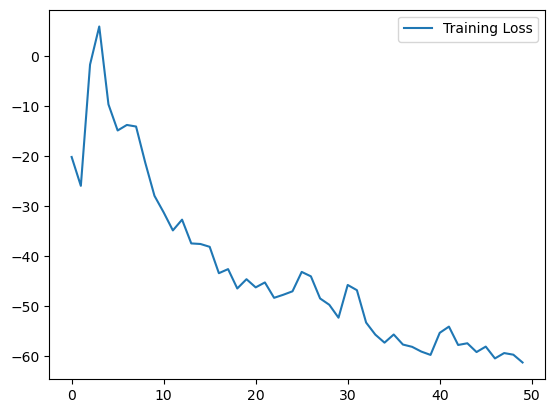

In [10]:
history = model.fit(x_train, epochs=50, batch_size=128, shuffle=False)
plt.plot(history.history["loss"], label="Training Loss")
plt.legend()
plt.show()

## Detecting anomalies
### We could set threshold my using train loss, and detect which points are anomalies

In [11]:
# Get prediction of train data
x_train_pred = model.decoder.predict(model.encoder.predict(x_train)[-1])
print("Predict train data done")

# Get test MAE loss.
x_test_pred = model.decoder.predict(model.encoder.predict(x_test)[-1])
print("Predict test data done")

2023-02-22 05:23:23.216148: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1350840000 exceeds 10% of free system memory.
2023-02-22 05:24:10.244902: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1350840000 exceeds 10% of free system memory.


Predict train data done


2023-02-22 05:24:12.023393: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 4275180000 exceeds 10% of free system memory.
2023-02-22 05:26:49.158198: W tensorflow/core/common_runtime/bfc_allocator.cc:456] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.98GiB (rounded to 4275180032)requested by op ConcatV2
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2023-02-22 05:26:49.159872: I tensorflow/core/common_runtime/bfc_allocator.cc:991] BFCAllocator dump for GPU_0_bfc
2023-02-22 05:26:49.159911: I tensorflow/core/common_runtime/bfc_allocator.cc:998] Bin (256): 	Total Chunks: 58, Chunks in use: 58. 14.5KiB allocated for chunks. 14.5KiB in use in bin. 636B client-requested in use in bin.
2023-02-22 05:26:49.159927: I tensorflow/core/common_runtime/bfc_allocator.cc:998] Bin (512): 	Total Chunks: 10, Chun

ResourceExhaustedError: OOM when allocating tensor with shape[427518,100,25] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:ConcatV2] name: concat

In [12]:
thresholds = {
    "abs_mean": compute_threshold(x_train, x_train_pred, option="abs_mean"),
    "abs_median": compute_threshold(x_train, x_train_pred, option="abs_median"),
    "abs_max": compute_threshold(x_train, x_train_pred, option="abs_max"),
    "square_mean": compute_threshold(x_train, x_train_pred, option="square_mean"),
    "square_median": compute_threshold(x_train, x_train_pred, option="square_median"),
    "rank": compute_threshold(x_train, x_train_pred, option="rank", label=df_test_label["label"]),
}
print(f'abs mean threshold: {thresholds["abs_mean"]:.3f}')
print(f'abs median threshold: {thresholds["abs_median"]:.3f}')
print(f'abs max threshold: {thresholds["abs_max"]:.3f}')
print(f'square mean threshold: {thresholds["square_mean"]:.3f}')
print(f'square median threshold: {thresholds["square_median"]:.3f}')
print(f'rank threshold: {thresholds["rank"]:.3f}')

# Detect all the samples which are anomalies.
test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)

abs mean threshold: 11.863
abs median threshold: 11.322
abs max threshold: 68.544
square mean threshold: 28.088
square median threshold: 13.063
rank threshold: 12.090


NameError: name 'x_test_pred' is not defined

In [ ]:
# Choose the lowest loss of the anomaly datas((# of anomalies)th) as threshold by using rank option
threshold = thresholds["abs_max"]
print(f"threshold: {threshold:.3f}")

fig = plt.figure(figsize=(16, 6))
ax = fig.add_subplot(111)

labels = df_test_label["label"].values.tolist()
dates = df_test.index


pd.DataFrame(np.sum(test_mae_loss, axis=1)).plot(ax=ax)
pd.DataFrame([threshold] * len(df_test)).plot(ax=ax)
ax.legend(["reconstruction error", "threshold"], loc="upper right")


temp_start = dates[0]
temp_date = dates[0]
temp_label = labels[0]

for xc, value in zip(dates, labels):
    if temp_label != value:
        if temp_label == True:
            ax.axvspan(temp_start, temp_date, alpha=0.2, color="orange")
        temp_start = xc
        temp_label = value
    temp_date = xc
if temp_label == True:
    ax.axvspan(temp_start, xc, alpha=0.2, color="orange")

## Predict & Evaluation


## #1 if any included time step has anomalies => abnormal

In [ ]:
# data i is an anomaly if samples [(i - timesteps + 1) to (i)] are anomalies
anomalies = np.sum(test_mae_loss, axis=1) > thresholds["abs_max"]
print("Number of anomaly samples: ", np.sum(anomalies))

anomalous_data_indices = []
for data_idx in range(TIME_STEPS - 1, len(df_test_value) - TIME_STEPS + 1):
    if np.all(anomalies[data_idx - TIME_STEPS + 1 : data_idx]):
        anomalous_data_indices.append(data_idx)
print("Number of anomalous samples: ", len(anomalous_data_indices))

test_pred = np.zeros(len(df_test))
test_label = df_test_label["label"]
test_pred[anomalous_data_indices] = 1

accuracy = (np.sum(test_pred == test_label)) / len(test_label)
precision = (np.sum(test_pred * test_label)) / np.sum(test_pred)
recall = (np.sum(test_pred * test_label)) / np.sum(test_label)
f1 = 2 * (precision * recall) / (precision + recall + 1e-7)

print(f"accuracy: {accuracy*100:.2f}%")
print(f"precision: {precision*100:.2f}%")
print(f"recall: {recall*100:.2f}%")
print(f"f1: {f1*100:.2f}%")

## #2 If half of included time steps has anomaly => abnormal

In [ ]:
# data i is an anomaly if ratio of anomalies sequences/involved total sequences >= 0.5
anomalies = np.sum(test_mae_loss, axis=1) > thresholds["abs_max"]
test_anomalies = np.zeros(len(df_test))
test_seqs = np.zeros(len(df_test))
test_label = df_test_label["label"]
print("Number of anomaly samples: ", np.sum(anomalies))

for idx, anomaly in enumerate(anomalies):
    test_seqs[idx : min(idx + TIME_STEPS, len(df_test))] += 1
    if anomaly:
        test_anomalies[idx : min(idx + TIME_STEPS, len(df_test))] += 1
test_pred_ratio = np.divide(test_anomalies, test_seqs)
test_pred = test_pred_ratio >= 0.5
print("Number of anomalous samples: ", sum(test_pred))


accuracy = (np.sum(test_pred == test_label)) / len(test_label)
precision = (np.sum(test_pred * test_label)) / np.sum(test_pred)
recall = (np.sum(test_pred * test_label)) / np.sum(test_label)
f1 = 2 * (precision * recall) / (precision + recall + 1e-7)

print(f"accuracy: {accuracy*100:.2f}%")
print(f"precision: {precision*100:.2f}%")
print(f"recall: {recall*100:.2f}%")
print(f"f1: {f1*100:.2f}%")

In [ ]:
idx = 4690
evaluation_array = [(test_seqs - test_anomalies)[idx:idx+400],
                    test_anomalies[idx:idx+400],
                    test_seqs[idx:idx+400],
                    test_pred_ratio[idx:idx+400],
                    test_pred[idx:idx+400],
                    df_test_label["label"][idx:idx+400]]

df = pd.DataFrame(evaluation_array, dtype=float)
df.index = ['Normal', 'Anomaly', '#Seq', 'Pred(%)', 'Pred', 'GT']
df.style.background_gradient(cmap='summer', axis=1)

### #3 we could find the threshold with highest f1 score by calculating all cases 


In [ ]:
from evaluator import evaluate

label = create_sequences(df_test_label["label"], TIME_STEPS)
print(label.shape)
scores = evaluate(x_test, x_test_pred, label, n=10, scoring="abs_mean")

In [ ]:
# print("f1:",np.max(scores['f1']))
idx = np.argmax(scores["f1"])

print(f"threshold: {scores['thresholds'][idx]}")
print(f"precision: {scores['precision'][idx]*100:.2f}%")
print(f"recall: {scores['recall'][idx]*100:.2f}%")
print(f"f1: {scores['f1'][idx]*100:.2f}%")